# A/B Testing - Choosing the Right Metric

A common problem in creating good A/B tests is knowing what metrics to measure, and for how long. 

All measures have some degree of "random" or "natural" variance - the numbers fluctuate for reasons you can't predict. Things like weather, holiday periods, economic conditions, or just natural human contraryness mean that the number you're measuring will be different from day to day, for reasons you can't explain. But some metrics are more subject to this kind of variance than others, and, generally speaking, the more data you collect, and the larger proportion of a population you sample, the more stable your measure will be. 

For A/B testing, the best metrics to pick are ones that have very little natural variance - in other words, measures that tend to be very stable over time. The more natural variance you have, the longer you'll need to run your experiment to get a true sense of the difference between your test and control groups.

In this notebook I'm going to demonstrate why, and show how it's surprsingly hard to get a "true" sense of the difference between two groups.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
% matplotlib inline

## Generate some data

Imagine two products that both generate random numbers between 1 and 20. One of them, "Roll Two" rolls two 20 sided dice and picks the highest. The other one, "Roll Three", rolls three 20 sided dice and picks the highest. It seems obvious that the second product will generally produce higher numbers, and if we wanted to choose the product that picked the highest numbers, we should go with "Roll Three".

In fact the expected value of "Roll Two" vs. "Roll Three" can be calculated mathematically, and "Roll Three" is around 1.67 "points" better - you can expect, over an infinite timeline, that the numbers it generates will be higher by 1.67.

But imagine we didn't know the interior workings of the two products, and we wanted to compare them simply by looking at their outputs. How many rolls would we have to see before we could be confident that one was better than the other?

In [80]:
data = pd.DataFrame([])
data['Product A'] = [8, 17, 17, 16, 19]
data['Product B'] = [18, 11, 8, 14, 10]

Here I've hand coded five results from each of the two products. I like to do this with actual dice in front of people, and hide which product is "Roll Two" and which is "Roll Three". Showing people the data, I ask them to guess which is which, decide how much better one product is than the other, and then, importantly, I ask them how confident they are that they've guessed correctly.

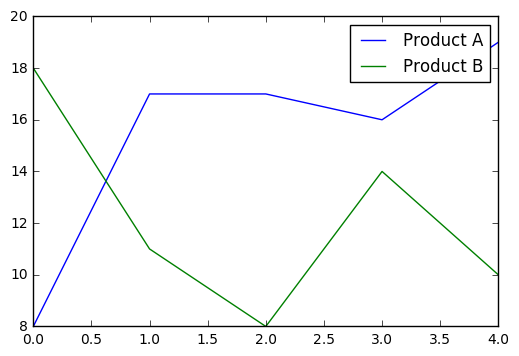

In [81]:
plt.plot(data[['Product A', 'Product B']])
plt.legend(['Product A', 'Product B'])
plt.show()

In [50]:
data.mean()

Product A    15.4
Product B    12.2
dtype: float64

Usually "Roll Three" performs better than "Roll Two", but sometimes it doesn't. And the difference between the two products is sometimes huge, and sometimes tiny. Do we have a good sense of what the true difference is?

## What if we did this 1,000 times?

By repeating the above experiment many times, we can understand more about whether it's a good test. The more often the test finds the "true" difference of 1.5, the better test it is.

I did 1,000 iterations of this, and plotted the difference in the averages for each iteration.

In [51]:
samples = 5

def simulate(samples):
    one = pd.Series([max([random.randint(1, 20) for i in range(3)]) for i in range(samples)])
    two = pd.Series([max([random.randint(1, 20) for i in range(2)]) for i in range(samples)])
    return one.mean() - two.mean()
                

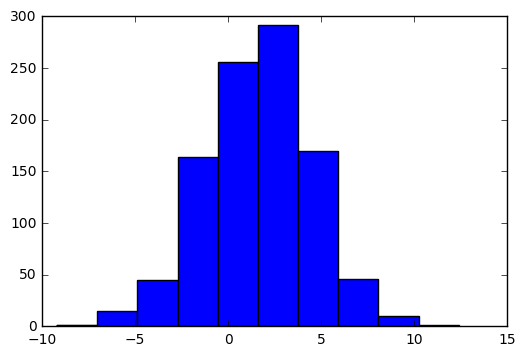

In [52]:
samples = 5

iterations = pd.Series([simulate(samples) for i in range(1000)])

plt.hist(iterations)
plt.show()

In [125]:
samples = 100

one = pd.Series([max([random.randint(1, 20) for i in range(3)]) for i in range(samples)])
two = pd.Series([max([random.randint(1, 20) for i in range(2)]) for i in range(samples)])

one.mean() - two.mean()

1.8399999999999999

In [112]:
iterations.mean()

1.7745999999999997

In [64]:
((iterations > 1.3) & (iterations < 1.8)).sum()/1000

0.058000000000000003

In [61]:
(iterations < 0).sum()/1000

0.27300000000000002

The histogram shows us that the results are clustered around the "true" difference, but on closer examination, only around 5% of tests found a result that was close to the true difference, and around a quarter of tests actually fgound that Roll Two was better than Roll Three!

Clearly, to get a true sense of the difference, we'll need to collect more than 5 samples.

## 100 Data Points

What happens when you have 100 data points, instead of 5? Here I have generated 100 data points, and then calculated an "expanding" average - the average after one example, the average after two, three, four and so on.

In [105]:
data1 = pd.DataFrame([])
data1['Roll Two'] = [max([random.randint(1, 20) for i in range(2)]) for i in range(100)]
data1['Roll Three'] = [max([random.randint(1, 20) for i in range(3)]) for i in range(100)]


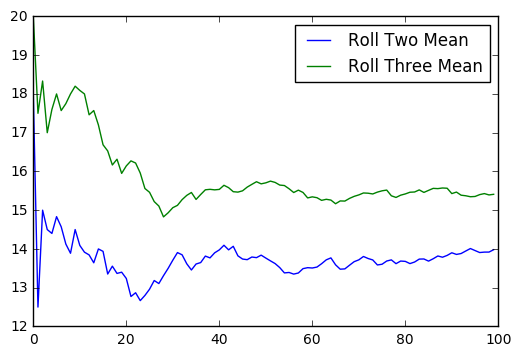

In [106]:
data1['Roll Two Mean'] = data1['Roll Two'].expanding(min_periods=1).mean()
data1['Roll Three Mean'] = data1['Roll Three'].expanding(min_periods=1).mean()
plt.plot(data1[['Roll Two Mean', 'Roll Three Mean']])

plt.legend(['Roll Two Mean', 'Roll Three Mean'])

plt.show()

You can see that the averages only "stabilise" after 40 or so data points. At various points the lines might come very close, or even cross. If you re-run this analysis, you can see that it gives very different results every time. Usually we get close to the "true" difference after 100 data points, but not always.

## 5 Simulations of 500 data points

Look what happens when you look at the difference between two dice and three dice over 500 iterations:

I ran 5 simulations. The average slowly approaches ~1.67, but it takes a long time to reach the "true" value, and some iterations show misleading averages for a long time.

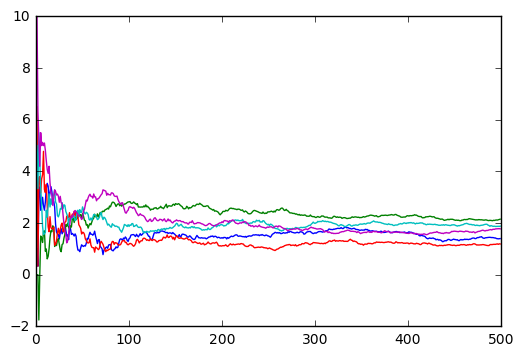

In [97]:
final_values = []

for i in range(5):
    data2 = pd.DataFrame([])
    data2['Roll Two'] = [max([random.randint(1, 20) for i in range(2)]) for i in range(500)]
    data2['Roll Three'] = [max([random.randint(1, 20) for i in range(3)]) for i in range(500)]

    data2['Roll Two Mean'] = data2['Roll Two'].expanding(min_periods=1).mean()
    data2['Roll Three Mean'] = data2['Roll Three'].expanding(min_periods=1).mean()
    data2['diff'] = data2['Roll Three Mean'] - data2['Roll Two Mean']
    plt.plot(data2['diff'][1:])
    final_values.append(data2['diff'].loc[499])

In [107]:
final_values

[1.4000000000000004,
 2.1519999999999992,
 1.1920000000000002,
 1.8800000000000008,
 1.7780000000000005]

Even after 500 samples, the tests don't all converge on the same point. They all approach the 1.67 "true" value, but none of them meet it exactly.

Does that mean that we can never know the true value of a product? Effectively yes. But. In real life, what matters is _material_ differences. Rather than asking "how much better is this product?" we should be asking "how confident are we that this product is having a _material_ effect for our users?".

So, when choosing metrics, and deciding how to build A/B experiments, we should approach them with the perspective of deciding how long we'll need to run them, and how much data we'll need to gather, to decide whether our product is having a material effect.

## Measuring if you have a meaningful result

Statisticians often talk about "p-values" as a measure of whether the result of an A/B test is "significant" or not. If you have a spare hour or so, ask them to define those terms. For myself, I like to use a demonstation which gives a slightly more human-readable metric.

We measure the observed difference between our two groups - "Roll Two" and "Roll Three" in this example - and then we compare that to a few thousand "random" differences, generated by randomly shuffling our observed values into test and control.

In [198]:
samples = 50

one = pd.Series([max([random.randint(1, 20) for i in range(3)]) for i in range(samples)])
two = pd.Series([max([random.randint(1, 20) for i in range(2)]) for i in range(samples)])

df = pd.DataFrame(one.append(two), columns=['score'])

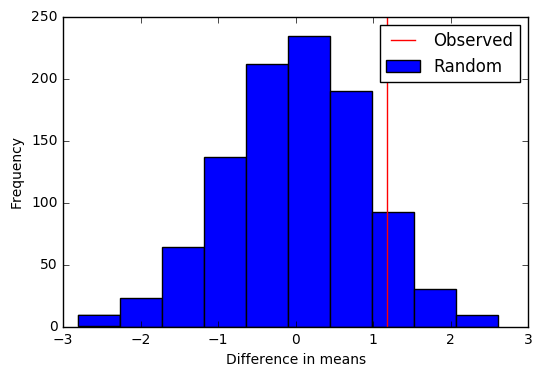

In [199]:
results = []

for i in range(1000):
    df['test_control'] = [random.randint(0,1) for i in range(2*samples)]
    diff = df[df.test_control == 1].score.mean() - df[df.test_control == 0].score.mean()
    results.append(diff)
    
pd.Series(results).plot(kind='hist')

plt.axvline(x=one.mean()-two.mean(), c='r')

plt.legend(['Observed', 'Random'])
plt.xlabel('Difference in means')
plt.show()

If the observed difference falls well inside the distribution of random differences, then we know there's a good possibility that our observed difference might be attributable to natural variation between our groups. The further the observed difference falls outside the random differences, the more confidence we can have that we are seeing a real difference between the two groups.

One of the good things about this approach is that it's quite robust, even if your data has very unusual distributions, and it's effective regardless of if you're measuring mean values (like in the above example) or if you're counting discrete pass/fail events.